## Load libs

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

## Data

In [2]:
from torchvision import datasets, transforms

batch_size = 128

# Load the CelebA dataset
transform = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize(64),
    transforms.ToTensor()
])

dataset = datasets.CelebA(root='./data', split='train', transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


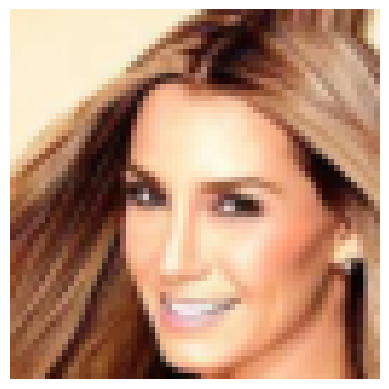

torch.Size([3, 64, 64])

In [3]:
import matplotlib.pyplot as plt

# Select a random image from the dataset
index = 0
image, _ = dataset[index]

# Display the image
plt.imshow(image.permute(1, 2, 0))  # convert from tensor to numpy array and rearrange the dimensions
plt.axis('off')
plt.show()

image.shape

## Model def

In [4]:
class VAE(nn.Module):
    def __init__(self, latent_size=20):
        super().__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
        )
        
        # Latent space
        self.fc_mu = nn.Linear(4*4*256, latent_size)
        self.fc_logvar = nn.Linear(4*4*256, latent_size)
        
        # Decoder
        self.fc_decoder = nn.Linear(latent_size, 4*4*256)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )
    
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def decode(self, z):
        h = self.fc_decoder(z)
        h = h.view(-1, 256, 4, 4)
        x_recon = self.decoder(h)
        return x_recon
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mu + eps*std
        return z
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

## Fit model

In [147]:
# Instantiate the VAE
latent_size=2
model = VAE(latent_size)

# Where to save model
# Change this after updating model definition
model_path = './models/vae_03.pth'

In [18]:
# Load the trained VAE
model = VAE(latent_size=2)
model.load_state_dict(torch.load('./models/vae_00_0.pth'))

<All keys matched successfully>

In [148]:
# Define the loss function and optimizer
def loss_fn(x_recon, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(x_recon, x) #, size_average=False)
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

lr = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [153]:
from tqdm.notebook import tqdm # status bar

num_epochs = 1

model.train()
for epoch in range(num_epochs):
    for batch_idx, (images, _) in enumerate(tqdm(dataloader)):
        
        x_recon, mu, logvar = model(images)
        loss = loss_fn(x_recon, images, mu, logvar)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (batch_idx+1) % 10 == 0:
            print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}"
                  .format(epoch+1, num_epochs, batch_idx+1, len(dataloader), loss.item()))
        
        if (batch_idx + 1) > 1/6*60:
            break
            
# Save the trained VAE
# torch.save(model.state_dict(), model_path)

  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [1/1], Step [10/1272], Loss: 8642.1260


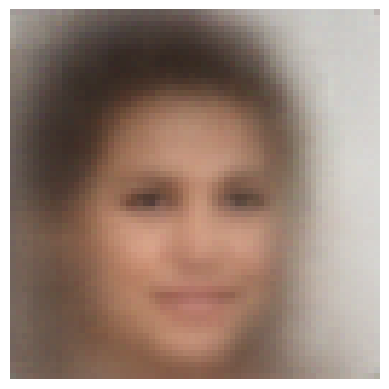

In [156]:
# Load the trained VAE
model = VAE(latent_size=2)
model.load_state_dict(torch.load('./models/vae_00_0.pth'))

# Generate new images
model.eval()
num_images = 1
z = torch.randn(num_images, 2)
new_image = model.decode(z)

# Display the image
plt.imshow(new_image.squeeze().detach().permute(1, 2, 0))  # convert from tensor to numpy array and rearrange the dimensions
plt.axis('off')
plt.show()